### **Quora Insincere questions Classification**

Importing the Libraries

In [43]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from sklearn import metrics
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score, recall_score
from scipy import sparse
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Reading the files

In [ ]:
# #Embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip

In [ ]:
!unzip train.csv.zip

quora_train_df = pd.read_csv('train.csv')

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
quora_train_df.shape

(1306122, 3)

**Data fields**

**qid** → unique question identifier \
**question_text** → Quora question text \
**target** → a question labeled 'insincere' has a value of **1**, otherwise **0**

An insincere question is defined as a question intended to make a statement rather than look for helpful answers


In [ ]:
quora_train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [ ]:
quora_train_df.target.value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [ ]:
def text_cleaning(text):

    #remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>@[\]^_`{|}~"""), ' ', text) 
    #remove urls
    text = re.sub('http\S+\s*', ' ', text)
    #remove hashtags
    text = re.sub('#\S+', '', text)
    #remove non-ascii characters
    text = re.sub(r'[^\x00-\x7f]',r' ', text)
    #remove mentions (i.e, @)
    text = re.sub('@\S+', '  ', text)
    #remove extra whitespaces, wherever applicable
    text = re.sub('\s+', ' ',text)
    #convert the text into lower
    text = text.lower()

    return text


In [ ]:
def question_clean(quora_train_df):

    clean_text = []

    for question in quora_train_df.question_text.to_list():
        clean_text.append(text_cleaning(question))

    return clean_text

In [ ]:
cleaned_text = question_clean(quora_train_df)

In [ ]:
#adding a new column into the data frame for the cleaned questions
quora_train_df['Cleaned_question_text'] = cleaned_text

**writing the cleaned data into CSV file**

In [ ]:
quora_train_df.to_csv('cleaned_train.csv')

In [ ]:
cleaned_quora_df = pd.read_csv('cleaned_train.csv')

In [ ]:
cleaned_quora_df.drop('Unnamed: 0',axis = 1, inplace = True)
cleaned_quora_df.head()

,qid,question_text,target,Cleaned_question_text
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,how did quebec nationalists see their province...
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,do you have an adopted dog how would you encou...
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,why does velocity affect time? does velocity a...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,how did otto von guericke used the magdeburg h...
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,can i convert montra helicon d to a mountain b...


**Feature Engineering**(Custom features)

In [ ]:
#adding new features to the data 
#stopwords
stop_words = set(stopwords.words('english'))

#average length of each question
cleaned_quora_df['avg_length'] = cleaned_quora_df['Cleaned_question_text'].apply(lambda x : np.mean([len(word) for word in str(x).split()]))
#number of words in the each question
cleaned_quora_df['Number_words'] = cleaned_quora_df["Cleaned_question_text"].apply(lambda x: len(str(x).split()))
#number of uniques words in the question 
cleaned_quora_df['unique_words'] = cleaned_quora_df["Cleaned_question_text"].apply(lambda x: len(set(str(x).split())))
#number of chracters in the question
cleaned_quora_df['num_char'] = cleaned_quora_df["Cleaned_question_text"].apply(lambda x: len(str(x)))
#number of stopwords in the question
cleaned_quora_df['num_of_stopwords'] = cleaned_quora_df["Cleaned_question_text"].apply(lambda x: len([word for word in str(x).lower().split() 
                                        if word in stop_words]))
#number of punctuations in the question
cleaned_quora_df['num_of_punc'] = cleaned_quora_df["question_text"].apply(lambda x: len([char for char in str(x) if char in string.punctuation]))
#number of title case words in each question
cleaned_quora_df['num_title_words'] = cleaned_quora_df["question_text"].apply(lambda x: len([word for word in str(x).split() if word.istitle()]))


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [ ]:
cleaned_quora_df.head()

,qid,question_text,target,Cleaned_question_text,avg_length,Number_words,unique_words,num_char,num_of_stopwords,num_of_punc,num_title_words
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,how did quebec nationalists see their province...,4.615385,13,13,72,7,1,2
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,do you have an adopted dog how would you encou...,4.062500,16,15,80,9,2,1
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,why does velocity affect time? does velocity a...,5.800000,10,7,67,3,2,2
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,how did otto von guericke used the magdeburg h...,5.444444,9,9,57,3,1,4
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,can i convert montra helicon d to a mountain b...,4.200000,15,15,77,8,1,3


In [ ]:
cleaned_quora_df.shape

(1306122, 11)

In [ ]:
#dropping the rows with null vlaues
cleaned_quora_df = cleaned_quora_df.dropna(axis=0, subset=['avg_length'])

In [ ]:
cleaned_quora_df.shape

(1306121, 11)

**splitting the data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_quora_df, cleaned_quora_df['target'],stratify=cleaned_quora_df['target'], test_size=0.33, random_state=42)

In [ ]:
X_train.head()

,qid,question_text,target,Cleaned_question_text,avg_length,Number_words,unique_words,num_char,num_of_stopwords,num_of_punc,num_title_words
552350,6c388e9b95bc18e6fc55,What's the function of polar bodies?,0,what s the function of polar bodies?,4.285714,7,7,36,4,2,0
1162169,e3b6e456e8c2d6d47a72,How do I begin everything from a new start in ...,0,how do i begin everything from a new start in ...,4.000000,12,12,59,6,1,2
568102,6f51deac9f2048c0f38f,How much cholesterol is too much?,0,how much cholesterol is too much?,4.666667,6,6,33,3,1,1
440031,563c0b590cd95bd84b8d,What are the options to deliver scripts to Ind...,0,what are the options to deliver scripts to ind...,4.636364,11,10,61,5,1,2
237922,2e898e1797cea7d491d3,Which insurance company in India provide healt...,0,which insurance company in india provide healt...,6.300000,10,9,72,3,1,2


In [ ]:
print(y_train.value_counts())
print(y_test.value_counts())
print(X_train.shape)
print(X_test.shape)

0    820959
1     54142
Name: target, dtype: int64
0    404353
1     26667
Name: target, dtype: int64
(875101, 11)
(431020, 11)


In [ ]:
#creating a dataframe for custom features
custom_features_train = X_train[["avg_length","Number_words","unique_words","num_char","num_of_stopwords","num_of_punc","num_title_words"]]
custom_features_test = X_test[["avg_length","Number_words","unique_words","num_char","num_of_stopwords","num_of_punc","num_title_words"]]

**Count Vectorizer**

Building a baseline model (Logistic Regression) with  count vectorizer

In [ ]:
vectorizer_lr = CountVectorizer(min_df=3)

In [ ]:
X_cv_train = vectorizer_lr.fit_transform(X_train['Cleaned_question_text'])
X_cv_test = vectorizer_lr.transform(X_test['Cleaned_question_text'])

In [ ]:
print(X_cv_train.shape)
print(X_cv_test.shape)

(875101, 55837)
(431020, 55837)


In [ ]:
#combined matrix with count vectors and custom features
X_train_df = sparse.hstack([X_cv_train,custom_features_train])
X_test_df = sparse.hstack([X_cv_test,custom_features_test])

In [ ]:
print(X_train_df.shape)
print(X_test_df.shape)

(875101, 55844)
(431020, 55844)


Standardization on the data:

In [ ]:
scalar = StandardScaler(with_mean = False)

ss_train_data = scalar.fit_transform(X_train_df)
ss_test_data = scalar.transform(X_test_df)

In [ ]:
print(ss_train_data.shape)
print(ss_test_data.shape)

(875101, 55844)
(431020, 55844)


#### **Tf-idf Vectorizer**
Building a baseline model (Logistic Regression) with TFIDF vectors

In [ ]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,3),min_df = 3,max_features=50000)

In [ ]:
X_train_tf_idf = vectorizer_tfidf.fit_transform(X_train['Cleaned_question_text'])
X_test_tf_idf = vectorizer_tfidf.transform(X_test['Cleaned_question_text'])

In [ ]:
print(X_train_tf_idf.shape)
print(X_test_tf_idf.shape)

(875101, 50000)
(431020, 50000)


Combining the custom features and tf-idf vecctors

In [ ]:
X_train_tf = sparse.hstack([X_train_tf_idf,custom_features_train])
X_test_tf = sparse.hstack([X_test_tf_idf,custom_features_test])

In [ ]:
print(X_train_tf.shape)
print(X_test_tf.shape)

(875101, 50007)
(431020, 50007)


Standardization

In [ ]:
scalar = StandardScaler(with_mean = False)

ss_train_data_tf = scalar.fit_transform(X_train_tf)
ss_test_data_tf = scalar.transform(X_test_tf)

In [ ]:
print(ss_train_data_tf.shape)
print(ss_test_data_tf.shape)

(875101, 50007)
(431020, 50007)


Machine Learning Models

**Logistic model**:
Using Grid search to tune hyperparamaters

In [ ]:
#l1 lasso and l2 ridge
grid = {"C":np.logspace(-3,3,7),"penalty":["l1","l2"]}
log_reg = LogisticRegression()
log_reg_cv = GridSearchCV(log_reg,grid,cv=3,scoring = "f1")

In [ ]:
log_reg_cv.fit(ss_train_data,y_train)

In [ ]:
print("Tuned hyperparameters : (best parameters)",log_reg_cv.best_params_)
print("accuracy",log_reg_cv.best_score_)

Tuned hyperparameters : (best parameters) {'C': 0.001, 'penalty': 'l2'}
accuracy 0.5234129816027563


#### **logistic Regression model with count Vectorizer and custom features**


In [ ]:
def logistic_reg(x_train,y_train,x_test,y_test):

    #applying the logidtic regression using sklearn
    logisticreg = LogisticRegression(C = 0.001,penalty = "l2")
    #fitting the model
    logisticreg.fit(x_train,y_train)
    #predicting
    y_pred_test = logisticreg.predict(x_test)
    y_pred_train = logisticreg.predict(x_train)
    #f1-score
    f1score_test  = f1_score(y_pred_test,y_test)
    f1score_train = f1_score(y_pred_train,y_train)
    #auc score
    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_pred_test,y_test)
    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_pred_train,y_train)
    
    auc_score_test = metrics.auc(fpr_test, tpr_test)
    auc_score_train = metrics.auc(fpr_train,tpr_train)
    #confusion matrix
    conf_mat_train = confusion_matrix(y_train,y_pred_train)
    conf_mat_test = confusion_matrix(y_test,y_pred_test)
    #recall
    recall_test = recall_score(y_pred_test,y_test) 
    recall_train = recall_score(y_pred_train,y_train) 

    return f1score_test,f1score_train,auc_score_test,auc_score_train,conf_mat_train,conf_mat_test,recall_test,recall_train


In [ ]:
f1score_test,f1score_train,auc_score_test,auc_score_train,conf_mat_train,conf_mat_test,recall_test,recall_train = logistic_reg(ss_train_data,y_train,ss_test_data,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
print(f"F1 score on test dataset is {f1score_test}")
print(f"F1 score on train dataset is {f1score_train}")
print(f"AUC score on test dataset is {auc_score_test}")
print(f"AUC score on train dataset  {auc_score_train}")
print(f"Recall score on test dataset  {recall_test}")
print(f"Recall score on train dataset  {recall_train}")


F1 score on test dataset is 0.5371029392381707
F1 score on train dataset is 0.6750972762645914
AUC score on test dataset is 0.8066648837766378
AUC score on train dataset  0.8814572809552724
Recall score on test dataset  0.6483691328560064
Recall score on train dataset  0.7895335608646189



Confusion matrix on train data

In [ ]:
conf_mat_train

array([[812449,   8510],
       [ 22218,  31924]])

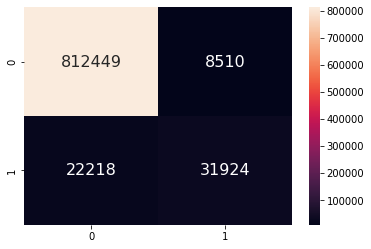

In [37]:
sns.heatmap(conf_mat_train, annot=True,annot_kws={"size": 16},fmt="")

plt.show()

Confusion matrix on test data

In [38]:
conf_mat_test

array([[397723,   6630],
       [ 14442,  12225]])

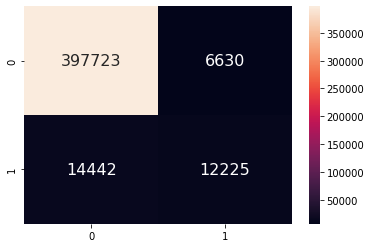

In [39]:
sns.heatmap(conf_mat_test, annot=True,annot_kws={"size": 16},fmt="")

plt.show()

Using Grid search to tune hyperparamaters

In [ ]:
log_reg_cv.fit(ss_train_data_tf,y_train)

In [ ]:
print("Tuned hyperparameters : (best parameters)",log_reg_cv.best_params_)
print("accuracy",log_reg_cv.best_score_)

Tuned hyperparameters : (best parameters) {'C': 0.001, 'penalty': 'l2'}
accuracy 0.5234129816027563


**logistic regression with tf-idf vectors and custom features**

In [49]:
f1score_test_tf,f1score_train_tf,auc_score_test_tf,auc_score_train_tf,conf_mat_train_tf,conf_mat_test_tf,recall_test_tf,recall_train_tf = logistic_reg(ss_train_data_tf,y_train,ss_test_data_tf,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [50]:
print(f"F1 score on test dataset is {f1score_test_tf}")
print(f"F1 score on train dataset is {f1score_train_tf}")
print(f"AUC score on test dataset is {auc_score_test_tf}")
print(f"AUC score on train dataset  {auc_score_train_tf}")
print(f"Recall score on test dataset  {recall_test_tf}")
print(f"Recall score on train dataset  {recall_train_tf}")

F1 score on test dataset is 0.5400772099718641
F1 score on train dataset is 0.6640095068830254
AUC score on test dataset is 0.8053802307053681
AUC score on train dataset  0.8719684513274373
Recall score on test dataset  0.6454488583046606
Recall score on train dataset  0.7709966542115417


Confusion Matrix on train data

In [51]:
conf_mat_train_tf

array([[811582,   9377],
       [ 22572,  31570]])

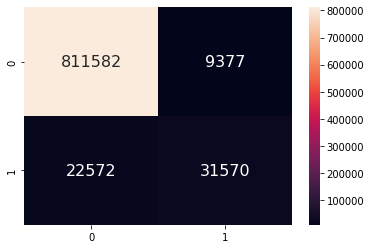

In [52]:
sns.heatmap(conf_mat_train_tf, annot=True,annot_kws={"size": 16},fmt="")
plt.show()

Confusion matrix on test data

In [53]:
conf_mat_test_tf

array([[397552,   6801],
       [ 14286,  12381]])

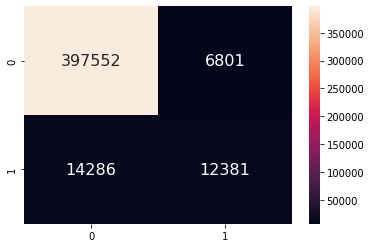

In [54]:
sns.heatmap(conf_mat_test_tf, annot=True,annot_kws={"size": 16},fmt="")
plt.show()

#### **Naive Bayes Model** 

In [ ]:
def naive_bayes(x_train,y_train,x_test,y_test):

    mnb = MultinomialNB()

    #fitting the model
    mnb.fit(x_train,y_train)
    #predicting the model
    y_pred_mnb = mnb.predict(x_test)
    #confusion matrix
    cm = confusion_matrix(y_pred_mnb,y_test)
    #f1score
    f1_score_mnb = f1_score(y_pred_mnb,y_test)
    #auc score
    fpr_nb, tpr_nb, thresholds_nb = metrics.roc_curve(y_test,y_pred_mnb,pos_label=1)
    auc_score_mnb = metrics.auc(fpr_nb,tpr_nb)
    #recall score
    recall = recall_score(y_pred_mnb,y_test)


    return f1_score_mnb,auc_score_mnb,cm,recall


Naive bayes with Count vectorizer and custom features

In [ ]:
f1_score_nv_cv,auc_score_mnb_cv,cm_nb_cv,recall_nb_cv = naive_bayes(X_train_df,y_train,X_test_df,y_test)

In [ ]:
print(f"F1 score on test dataset is {f1_score_nv_cv}")
print(f"AUC score on test dataset is {auc_score_mnb_cv}")
print(f"Recall score on test dataset is {recall_nb_cv}")


F1 score on test dataset is 0.5487451199107641
AUC score on test dataset is 0.8375806013486701
Recall score on test dataset is 0.43677446562936983


Naive bayes with tf_idf vectorizer and custom features

In [ ]:
f1_score_nv_cv,auc_score_mnb_cv,cm_nb_cv,recall_nb_cv = naive_bayes(X_train_tf,y_train,X_test_tf,y_test)

In [ ]:
print(f"F1 score on test dataset is {f1_score_nv_cv}")
print(f"AUC score on test dataset is {auc_score_mnb_cv}")
print(f"Recall score on test dataset is {recall_nb_cv}")


F1 score on test dataset is 0.4843647598539463
AUC score on test dataset is 0.6869431626101256
Recall score on test dataset is 0.6443918540200536


**Support Vector Machine**

Using the Count vectorizer

In [77]:
svc = LinearSVC(dual=True,C=5,penalty='l2',max_iter=1000,tol=0.1)
svc.fit(ss_train_data, y_train)
pred_cv = svc.predict(ss_test_data)
pred1_cv = svc.predict(ss_train_data)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [79]:
print("F1 score on test data: %s" % f1_score(pred_cv,y_test))
print("Recall score on test data: %s" % f1_score(pred_cv,y_test))
print("F1 score on train data: %s" % f1_score(pred1_cv,y_train))
print("Recall score on train data: %s" % recall_score(pred1_cv,y_train))

F1 score on test data: 0.437715007101152
Recall score on test data: 0.437715007101152
F1 score on train data: 0.5122184278956108
Recall score on train data: 0.44467865205211193


Using the tf-idf vectorizer

In [76]:
svc_tf = LinearSVC(dual=True,C=5,penalty='l2',max_iter=1000,tol=0.01)
svc_tf.fit(ss_train_data_tf, y_train)
pred = svc_tf.predict(ss_test_data_tf)
pred1 = svc_tf.predict(ss_train_data_tf)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [80]:
print("F1 score on test data: %s" % f1_score(pred,y_test))
print("Recall score on test data: %s" % f1_score(pred,y_test))
print("F1 score on train data: %s" % f1_score(pred1,y_train))
print("Recall score on train data: %s" % f1_score(pred1,y_train))

F1 score on test data: 0.4214138886406292
Recall score on test data: 0.4214138886406292
F1 score on train data: 0.5052502302732577
Recall score on train data: 0.5052502302732577
